# Load basic config

In [1]:
import qubecalib as qc
import qubecalib.ui as ui
from qubecalib import UpConverter, LocalOscillator
from qubecalib.ui import Qube
import e7awgsw

QUBE = Qube(config_file_name='qube_riken_1-10.yml')
display(ui.LoadConfigPanel(QUBE))
# ハードウェアのコンフィグが終わっていれば，Load した時点で Qube オブジェクトから QuBE を操れる
display(ui.ipw.HBox([ui.ConfigFPGA(QUBE), ui.InitializeLSIs(QUBE), ui.RestartAD9082(QUBE)]))

LoadConfigPanel(children=(Text(value='qube_riken_1-10.yml', description='Config'), Button(description='Load', …

In [2]:
QUBE.config

{'bitfile': '0d5ea1.bit',
 'ipfpga': '10.1.0.28',
 'iplsi': '10.5.0.28',
 'macfpga': '00-0A-35-0D-5E-A1',
 'maclsi': '00-1B-1A-EE-01-27',
 'type': 'A'}

# Frequency Setup

In [194]:
qc.set_sideband_config(QUBE.qube.adrf6780, qube_type='A')

TARGET = 9611
LO = 8500 # 500M
IF = 1093.75 # (111//15.625)*15.625
FAWG0 = TARGET - LO - IF
print(FAWG0)

p = QUBE.qube.ports[0] # Resonant Frequency 9611 MHz
p.set_lo(LO)
p.set_if(IF)
#set_vatt(p.upconv.vatt, 0x700) # Max -45.93 dBm
qc.set_vatt(p.upconv.vatt, 0x600) # -49 dBm
# RF = 9611 MHz = 8100 + 1400 + 111

QUBE.qube.ad9082[0].set_nco(freq=IF*1e+6, ch=3, adc_mode=True)
QUBE.qube.ad9082[1].set_nco(freq=IF*1e+6, ch=3, adc_mode=True)
_ = [print(k, v.get_status()) for k, v in QUBE.qube.ports.items()]

17.25
0 RF = 9593.750 MHz LO =  8500    MHz IF = 1093.750 MHz LSB/USB: USB MODE AWG: Active
1 RF = 9500.000 MHz LO =  8500    MHz IF = 1000.000 MHz 
5 RF = 9900.000 MHz LO = 10900    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive
6 RF = 13000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: USB MODE AWG: Inactive
7 RF = 11000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive
8 RF = 11000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive
12 RF = 13000.000 MHz LO = 12000    MHz IF = 1000.000 MHz 
13 RF = 13000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: USB MODE AWG: Inactive


# Long Send

In [276]:
qc.LongSend.start(QUBE.qube.ports[0],atts=[0,])#,freqs=[19,]*3) # dBatt
#qc.LongSend.start(QUBE.qube.ports[0],atts=[0,100,100])#,freqs=[19,]*3) # dBatt

In [277]:
qc.LongSend.stop(QUBE.qube.ports[0])

In [2]:
ui.ConfigFPGA(QUBE)

ConfigFPGA(children=(Button(description='Config FPGA', style=ButtonStyle()),))

# 単発のパルス送信

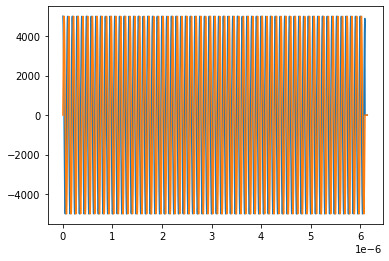

In [264]:
import math
import numpy as np
from e7awgsw import AWG, AwgCtrl, WaveSequence, SinWave, IqWave

def gen_wave_samples(duration, freq, amp=32767): # duration [s], freq [Hz]
    num_cycles = 64 #duration * freq
    i_samples = SinWave(num_cycles = num_cycles, frequency = freq, amplitude = amp, phase = math.pi / 2).gen_samples(AwgCtrl.SAMPLING_RATE)
    q_samples = SinWave(num_cycles = num_cycles, frequency = freq, amplitude = amp).gen_samples(AwgCtrl.SAMPLING_RATE)
    return (i_samples, q_samples)

def gen_wave_seq(duration, freq, amp=5000): # duration [s], freq [Hz]
    wave_seq = WaveSequence(
        num_wait_words = 0,
        num_repeats = 1)
    
    i_samples, q_samples = gen_wave_samples(duration, freq, amp)
    iq_samples = IqWave.convert_to_iq_format(i_samples, q_samples, padding_size = WaveSequence.NUM_SAMPLES_IN_WAVE_BLOCK)
    
    wave_seq.add_chunk(
        iq_samples = iq_samples,
        num_blank_words = 0, 
        num_repeats = 1)
    return wave_seq

awgs = [AWG.U15,]
awg_ctrl = AwgCtrl(QUBE.config['ipfpga'])
awg_ctrl.initialize(*awgs)
wave_seq = gen_wave_seq(1000e-9, 10.5e+6)
for awg in awgs:
    awg_ctrl.set_wave_sequence(awg, wave_seq)
awg_ctrl.start_awgs(*awgs)

%matplotlib inline
import matplotlib.pyplot as plt

w = np.array(wave_seq.all_samples())
plt.plot(np.arange(w.shape[0]) / AwgCtrl.SAMPLING_RATE, w[:,0])
plt.plot(np.arange(w.shape[0]) / AwgCtrl.SAMPLING_RATE, w[:,1])

# 共振器の読み出しテスト

17.25
9611.0


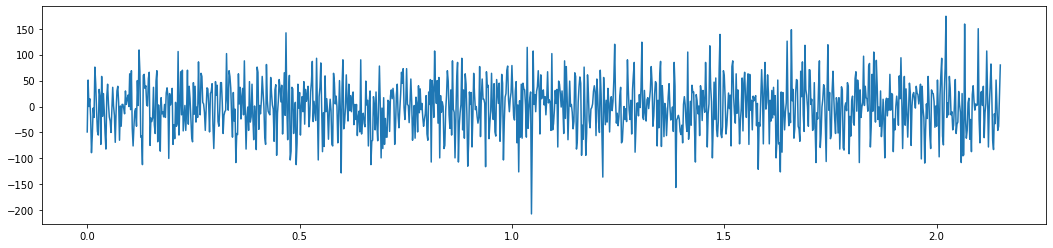

In [212]:
import e7awg_sw.examples.send_recv_dsp.send_recv_integ as sr
from e7awg_sw.examples.send_recv_dsp.send_recv_integ import AWG

from collections import namedtuple
import pickle
import numpy as np

qube = QUBE.qube
port = qube.ports

sr.IP_ADDR = QUBE.config['ipfpga']
AWG_LIST = sr.awg_list(
    ctrl_awg_0 = AWG.U0,
    ctrl_awg_1 = AWG.U13,
    readout_awg_0 = AWG.U2,
    readout_awg_1 = AWG.U15
)
sr.AWG_LIST = AWG_LIST

ctrl_wave_len = 100
capture_modules = sr.CaptureModule.all()
server_ip_addr = 'localhost'

p = QUBE.qube.ports[5]
p.set_lo(10900)
p.set_if(2700)
p.get_status()
qc.set_vatt(p.upconv.vatt, 0x400)

sr.ADDITIONAL_CAPTURE_DELAY = 0

TARGET = 9611
LO = 8500 # 500M
IF = 1093.75 # (111//15.625)*15.625
FAWG0 = TARGET - LO - IF
print(FAWG0)

p = QUBE.qube.ports[0] # Resonant Frequency 9611 MHz
p.set_lo(LO)
p.set_if(IF)
p.get_status()
#set_vatt(p.upconv.vatt, 0x700) # Max -45.93 dBm
qc.set_vatt(p.upconv.vatt, 0x800) # -49 dBm
# RF = 9611 MHz = 8100 + 1400 + 111

# 波形も 64 サンプルの倍数で作成する

QUBE.qube.ad9082[0].set_nco(freq=IF*1e+6, ch=3, adc_mode=True)
QUBE.qube.ad9082[1].set_nco(freq=IF*1e+6, ch=3, adc_mode=True)


#IF = TARGET - LO - FAWG0

#FAWG0 = 9711 - LO - IF


#Fawg = 151 # MHz

rslt = []
iq_mean = []
for Fawg in [FAWG0,]:# + 10*np.linspace(-1,1,21):
# 0.1374435494319231for Fawg in 111 + np.ones(11):
    print(LO + IF + Fawg)
    wparams = sr.wave_params(
        num_wait_words = 0,
        ctrl_freq = 100, # MHz
        ctrl_wave_len = ctrl_wave_len, # ns
        readout_freq = Fawg, # MHz,
        readout_wave_len = 1000, # ns,
        readout_blank_len = 0.1, # ms
        # num_chunk_repeats = 10000, # 積算回数
        num_chunk_repeats = 1# 積算回数
    )
    
    # _ = [print(k, v.get_status()) for k, v in QUBE.qube.ports.items()]
    
    family_no, personal_id = QUBE.config_file_name.split('_')[2].split('.')[0].split('-')
    fname = 'Qube{}_{}_readin.pickle'.format(family_no, personal_id)
    #[set_nco_ifadc(port[0], 1400, i) for i in range(4)] # とりあえず全チャンネルを設定 ADC IF 設定
    QUBE.qube.ad9082[0].set_nco(freq=IF*1e+6, ch=3, adc_mode=True)
    QUBE.qube.ad9082[1].set_nco(freq=IF*1e+6, ch=3, adc_mode=True)
    d = qc.sendrecv(wparams, capture_modules, False, server_ip_addr)
    rslt.append(d)
    
    %matplotlib inline
    import numpy as np
    import matplotlib.pylab as plt

    f, axs = plt.subplots(1,1, figsize=(18,4))
    SAMPLING_RATE = sr.CaptureCtrl.SAMPLING_RATE
    o = [np.array(v) for k, v in d.items()]
    time = np.linspace(0, 1e+6 * o[-1].shape[0] / SAMPLING_RATE, o[-1].shape[0], endpoint=False)
    local = np.exp(-1j*(2*np.pi*Fawg*time))
    i, v = 0, o[4]
    w = v[:,0] + 1j * v[:,1]
    x = w# * local
    #iq_mean.append(np.mean(x))
    #axs[i,0].plot(time, np.abs(x))#np.real(x))
    axs.plot(time, np.real(x))
    # axs[i,1].plot(time, np.unwrap(np.angle(x)))
    #axs[i,0].set_ylim(0,2e+5)
    plt.show()

# AWGの波形も同時に記録

In [25]:
10500 - 2265.625 - 2.5

8231.875

In [5]:
QUBE.qube.ports[5].get_status()

'RF = 11000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive'

2.5
9609.5 100 

IndexError: index 0 is out of bounds for axis 0 with size 0

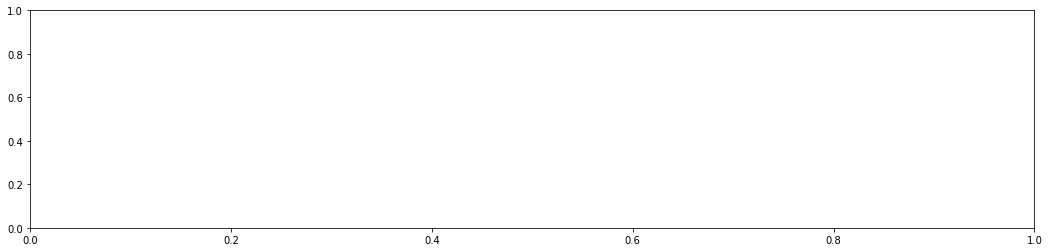

In [10]:
import e7awg_sw.examples.send_recv_dsp.send_recv_integ as sr
from e7awg_sw.examples.send_recv_dsp.send_recv_integ import AWG, CaptureModule
from collections import namedtuple
import pickle

qube = QUBE.qube
port = qube.ports

sr.IP_ADDR = QUBE.config['ipfpga']
AWG_LIST = sr.awg_list(
    ctrl_awg_0 = AWG.U0,
    ctrl_awg_1 = AWG.U13, # P5
    readout_awg_0 = AWG.U2,
    readout_awg_1 = AWG.U15 # P13
)
sr.AWG_LIST = AWG_LIST

ctrl_wave_len = 100
capture_modules = sr.CaptureModule.all()
server_ip_addr = 'localhost'


# p.set_lo(10500)
# p.set_if(2265.625)
# print(10500-2265.625-8231)
# p.get_status()

CTARGET = 8231
CLO = 10500
CIF = 2265.625
CAWG = (CLO - CIF) - CTARGET
CAWG = 2.5
print(CAWG)

p = QUBE.qube.ports[8]
p.set_lo(CLO)
p.set_if(CIF)
p.get_status()
qc.set_vatt(p.upconv.vatt, 0xA00)



sr.ADDITIONAL_CAPTURE_DELAY = 0

TARGET = 9609.5
LO = 8500 # 500M
IF = 1093.75 # (111//15.625)*15.625
FAWG0 = TARGET - LO - IF
# TARGET = LO + (IF + FAWG0)


# CIF = 
# IF = 2265.625
for o in QUBE.qube.ad9082:
    for i in range(4):
        o.set_nco(freq=CIF*1e+6, ch=i)
for o in QUBE.qube.ad9082:
    for i in range(4):
        o.set_nco(freq=IF*1e+6, ch=i, adc_mode=True)


p = QUBE.qube.ports[0] # Resonant Frequency 9611 MHz
p.set_lo(LO)
p.set_if(IF) # <- TODO: 要修正
p.get_status()
#set_vatt(p.upconv.vatt, 0x700) # Max -45.93 dBm
qc.set_vatt(p.upconv.vatt, 0x600) # -49 dBm
qc.set_vatt(p.upconv.vatt, 0xA00) # -49 dBm
# RF = 9611 MHz = 8100 + 1400 + 111

# 波形も 64 サンプルの倍数で作成する

QUBE.qube.ad9082[0].set_nco(freq=IF*1e+6, ch=3, adc_mode=True)
QUBE.qube.ad9082[1].set_nco(freq=IF*1e+6, ch=3, adc_mode=True)




#IF = TARGET - LO - FAWG0

#FAWG0 = 9711 - LO - IF


#Fawg = 151 # MHz

%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import scipy.signal
f, axs = plt.subplots(1,1, figsize=(18,4))


rslt = []
iq_mean = []
Fawg = FAWG0
for ctrl_wave_len in [100,]:#np.arange(100,201,10):# + 10*np.linspace(-1,1,21):|
# 0.1374435494319231for Fawg in 111 + np.ones(11):
    print(LO + IF + Fawg, ctrl_wave_len, end=' ')
    wparams = sr.wave_params(
        num_wait_words = 0,
        ctrl_freq = CAWG, # MHz
        ctrl_wave_len = ctrl_wave_len, # ns
        readout_freq = Fawg, # MHz,
        readout_wave_len = 1000, # ns,
        readout_blank_len = 0.1, # ms
        # num_chunk_repeats = 10000, # 積算回数
        num_chunk_repeats = 1# 積算回数
    )
    
    # _ = [print(k, v.get_status()) for k, v in QUBE.qube.ports.items()]
    
    family_no, personal_id = QUBE.config_file_name.split('_')[2].split('.')[0].split('-')
    fname = 'Qube{}_{}_readin.pickle'.format(family_no, personal_id)
    #[set_nco_ifadc(port[0], 1400, i) for i in range(4)] # とりあえず全チャンネルを設定 ADC IF 設定
    QUBE.qube.ad9082[0].set_nco(freq=IF*1e+6, ch=3, adc_mode=True)
    QUBE.qube.ad9082[1].set_nco(freq=IF*1e+6, ch=3, adc_mode=True)
    d = qc.sendrecv(wparams, capture_modules, False, server_ip_addr)
    rslt.append(d)
    
#     %matplotlib inline
#     import numpy as np
#     import matplotlib.pylab as plt
#     import scipy.signal
    
#     f, axs = plt.subplots(1,1, figsize=(18,4))
    SAMPLING_RATE = sr.CaptureCtrl.SAMPLING_RATE
    o = [np.array(v) for k, v in d.items()]
    time = np.linspace(0, 1e+6 * o[-1].shape[0] / SAMPLING_RATE, o[-1].shape[0], endpoint=False)
    v = o[4]
    i = scipy.signal.find_peaks(v[:1000,0],threshold=1e+7)[0]
    idx = i[0]
    local = np.exp(-1j*(2*np.pi*Fawg*(time-time[idx])))
    #local = np.exp(-1j*(2*np.pi*Fawg*time))
    w = v[:,0] + 1j * v[:,1]
    x = w * local
    #iq_mean.append(np.mean(x))
    #axs[i,0].plot(time, np.abs(x))#np.real(x))
    # axs.plot(time[idx+200:idx+450], np.real(x)[idx+200:idx+450])
    # axs.plot(time[idx+200:idx+450], np.imag(x)[idx+200:idx+450])
    axs.plot(np.real(x)[idx+200:idx+450].mean(), np.imag(x)[idx+200:idx+450].mean(),'.')
    print(time[i], i, idx)
    # axs[i,1].plot(time, np.unwrap(np.angle(x)))
    axs.set_aspect('equal')
    axs.set_xlim(-0.5e+7,0.5e+7)
    axs.set_ylim(-0.5e+7,0.5e+7)
    # plt.show()

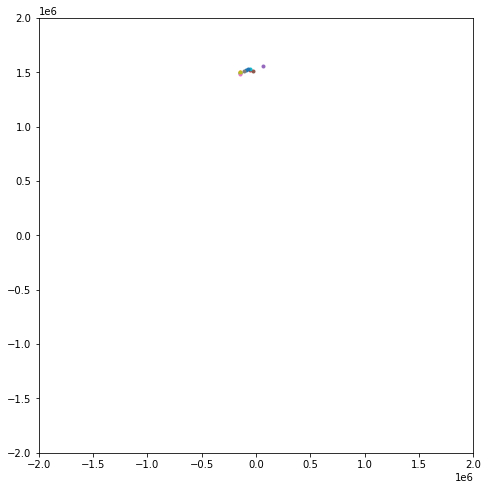

In [107]:
SAMPLING_RATE = sr.CaptureCtrl.SAMPLING_RATE
f, axs = plt.subplots(1,1, figsize=(8,8))
for d in rslt:
    o = [np.array(v) for k, v in d.items()]
    time = np.linspace(0, 1e+6 * o[-1].shape[0] / SAMPLING_RATE, o[-1].shape[0], endpoint=False)
    v = o[4]
    i = scipy.signal.find_peaks(v[:1000,0],threshold=1e+7)[0]
    idx = i[0]
    local = np.exp(-1j*(2*np.pi*Fawg*(time-time[idx])))
    w = v[:,0] + 1j * v[:,1]
    x = w * local
    axs.plot(np.real(x)[idx+200:idx+450].mean(), np.imag(x)[idx+200:idx+450].mean(),'.')
    axs.set_aspect('equal')
    axs.set_xlim(-0.2e+7,0.2e+7)
    axs.set_ylim(-0.2e+7,0.2e+7)


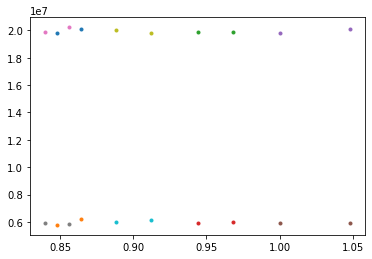

In [109]:
import numpy as np
import scipy.signal
for o in rslt:
    r = np.array(o[4])
    i = scipy.signal.find_peaks(r[:1000,0],threshold=1e+7)[0]#,distance=500*0.9)[0]
    plt.plot(time[i],r[i],'.')

[0.838 1.844] [419 922]


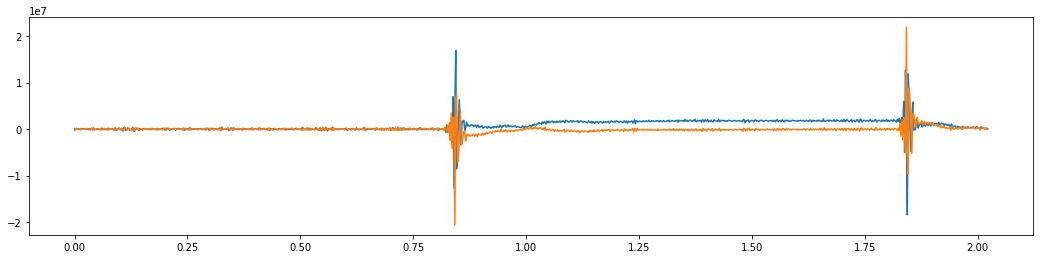

[0.864 1.87 ] [432 935]


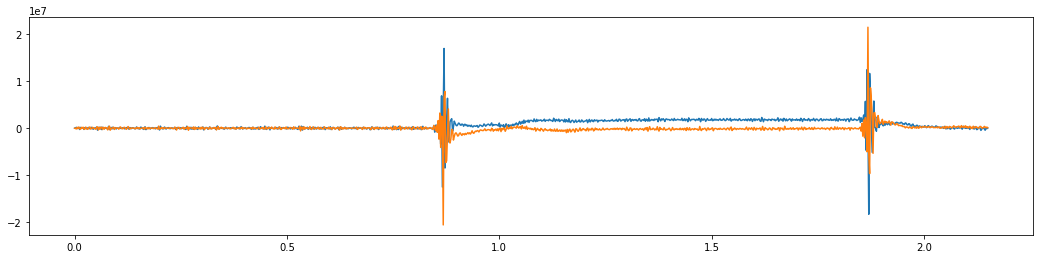

[0.858 1.864] [429 932]


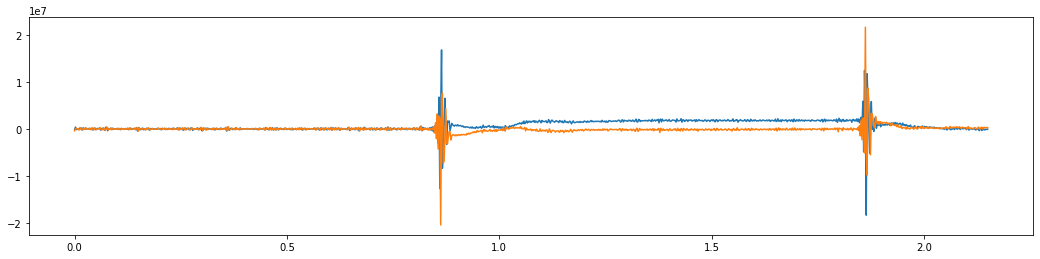

[0.788 1.794] [394 897]


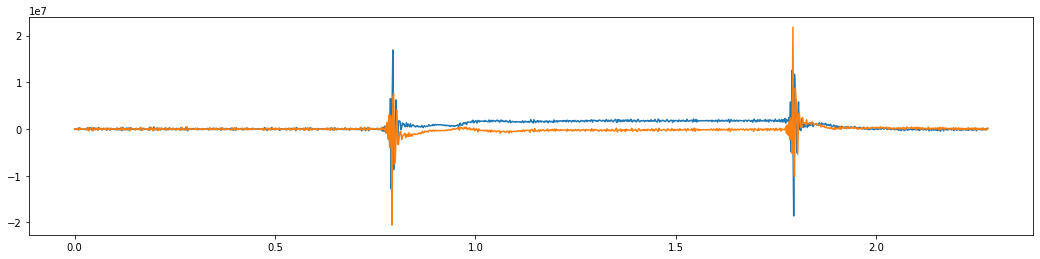

[1.006] [503]


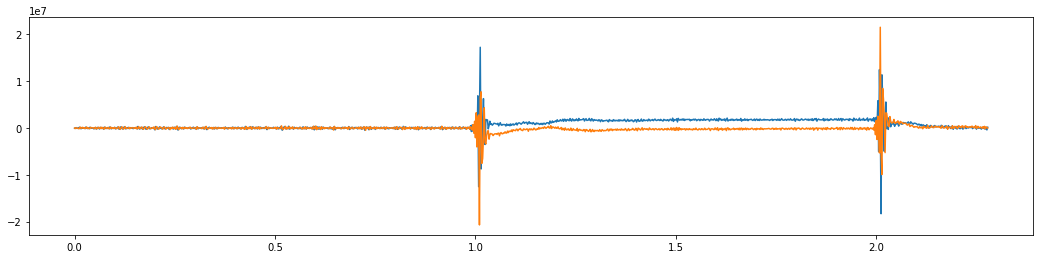

[0.744 1.75 ] [372 875]


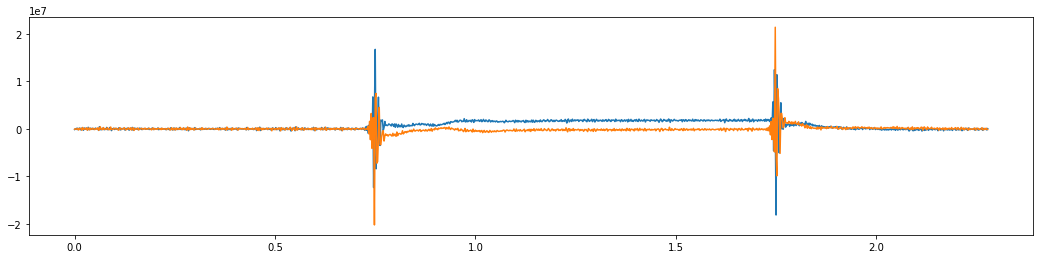

[0.842 1.848] [421 924]


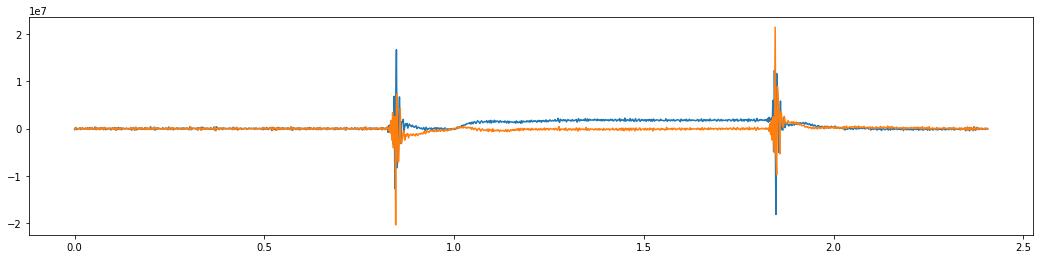

[0.868 1.874] [434 937]


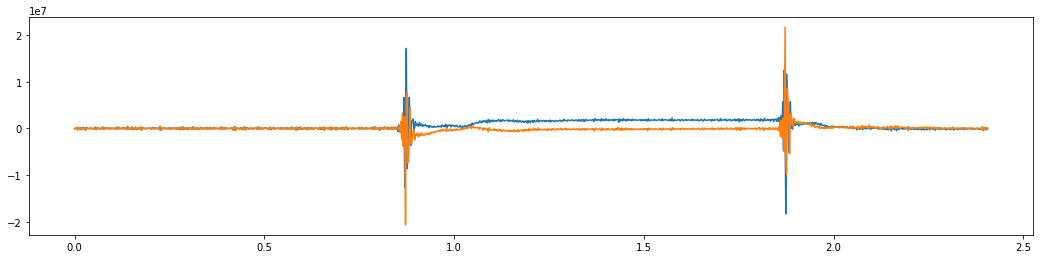

[0.878 1.884] [439 942]


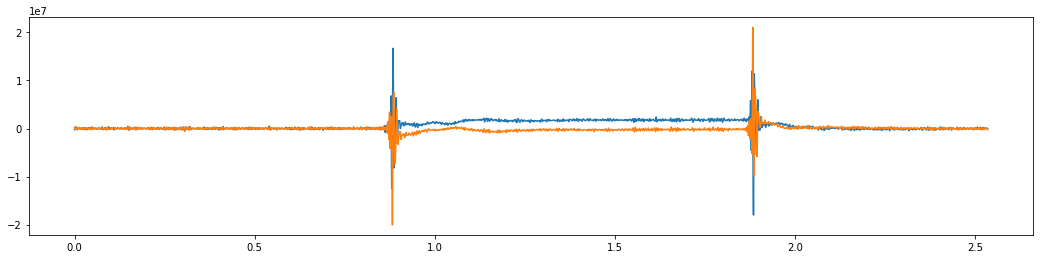

[0.84  1.846] [420 923]


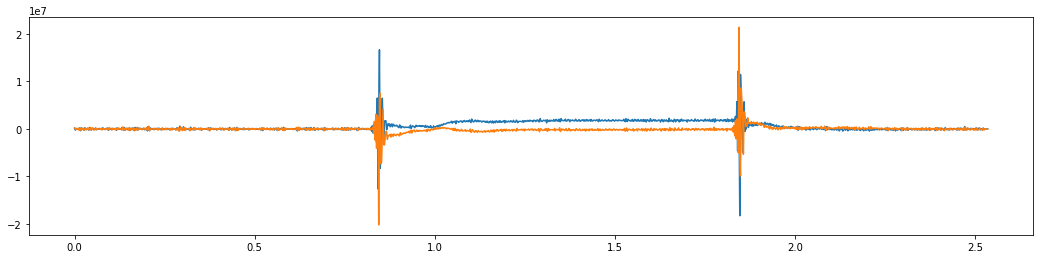

[0.906 1.912] [453 956]


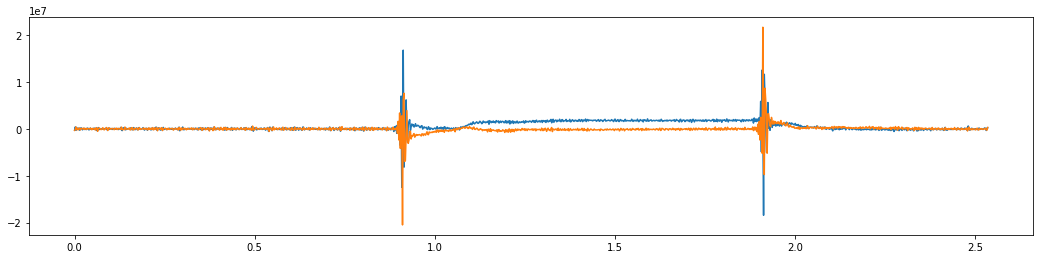

In [45]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import scipy.signal

for d in rslt:
    f, axs = plt.subplots(1,1, figsize=(18,4))
    SAMPLING_RATE = sr.CaptureCtrl.SAMPLING_RATE
    o = [np.array(v) for k, v in d.items()]
    time = np.linspace(0, 1e+6 * o[-1].shape[0] / SAMPLING_RATE, o[-1].shape[0], endpoint=False)
    v = o[4]
    i = scipy.signal.find_peaks(v[:1000,0],threshold=1e+7)[0]
    local = np.exp(-1j*(2*np.pi*Fawg*(time-time[i[0]])))
    #local = np.exp(-1j*(2*np.pi*Fawg*time))
    w = v[:,0] + 1j * v[:,1]
    x = w * local
    #iq_mean.append(np.mean(x))
    #axs[i,0].plot(time, np.abs(x))#np.real(x))
    axs.plot(time, np.real(x))
    axs.plot(time, np.imag(x))
    print(time[i], i)
    # axs[i,1].plot(time, np.unwrap(np.angle(x)))
    #axs.set_ylim(-0.5e+7,0.5e+7)
    plt.show()

In [101]:
r = np.array(rslt[1][4])
time[scipy.signal.find_peaks(r[:,0],distance=500*0.9)[0]]

array([0.062, 0.968, 2.252])

In [ ]:
type(rslt[0]['awd'])

In [72]:
import pickle

with open('RikenRabi20220414.pickle', 'wb') as f:
    pickle.dump(rslt, f)

with open('RikenRabi20220414.pickle', 'rb') as f:
    r = pickle.load(f)
    
rslt == r

True

4
64


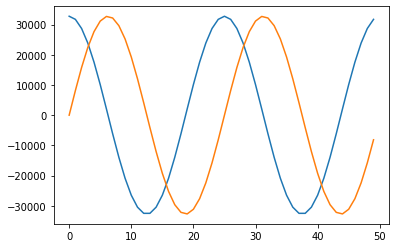

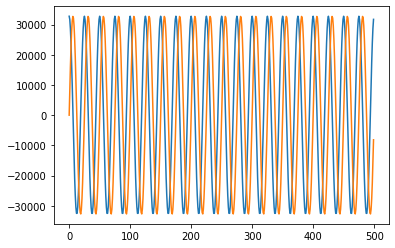

550 550 576
12493 (576, 2) 26
12621 (64, 2) 50548


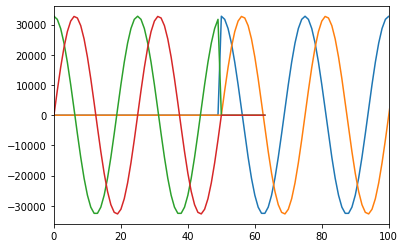

In [41]:
import e7awg_sw.examples.send_recv_dsp.send_recv_integ as sr
from e7awg_sw.examples.send_recv_dsp.send_recv_integ import AWG, CaptureModule
import e7awgsw
import math

%matplotlib inline
import numpy as np
import matplotlib.pylab as plt


AWG_LIST = sr.awg_list(
    ctrl_awg_0 = AWG.U0,
    ctrl_awg_1 = AWG.U13, # P5
    readout_awg_0 = AWG.U2,
    readout_awg_1 = AWG.U15 # P13
)

ctrl_wave_len = 100

Fawg = 20

params = sr.wave_params(
    num_wait_words = 0,
    ctrl_freq = 20, # MHz
    ctrl_wave_len = ctrl_wave_len, # ns
    readout_freq = Fawg, # MHz,
    readout_wave_len = 1000, # ns,
    readout_blank_len = 0.1, # ms
    # num_chunk_repeats = 10000, # 積算回数
    num_chunk_repeats = 1# 積算回数
)

awg_ctrl = e7awgsw.AwgCtrl('10.1.0.22')
awg_ctrl.initialize(e7awgsw.AWG.U13)

def gen_cos_wave(freq, num_cycles, amp, sampling_rate):
    freq = freq * 1e6
    i_samples = e7awgsw.SinWave(num_cycles = num_cycles, frequency = freq, amplitude = amp, phase = math.pi / 2).gen_samples(sampling_rate)
    # print(i_samples)
    # %matplotlib inline
    # import numpy as np
    # import matplotlib.pylab as plt
    q_samples = e7awgsw.SinWave(num_cycles = num_cycles, frequency = freq, amplitude = amp).gen_samples(sampling_rate)
    plt.figure()
    plt.plot(i_samples)
    plt.plot(q_samples)
    plt.show()
    return (i_samples, q_samples)

def gen_ctrl_wave_samples(params):
    num_cycles = params.ctrl_freq * params.ctrl_wave_len * 1e-3
    return gen_cos_wave(params.ctrl_freq, num_cycles, 32760, e7awgsw.AwgCtrl.SAMPLING_RATE)

def gen_readout_wave_samples(params, num_pre_blank_samples):
    num_cycles = params.readout_freq * params.readout_wave_len * 1e-3
    i_samples, q_samples = gen_cos_wave(params.readout_freq, num_cycles, 32760, e7awgsw.AwgCtrl.SAMPLING_RATE)
    i_samples = [0] * num_pre_blank_samples + i_samples # <- ここでブランクを作っている
    q_samples = [0] * num_pre_blank_samples + q_samples # <- ここでブランクを作っている
    return (i_samples, q_samples)

def gen_readout_wave_seq(params, i_samples, q_samples):
    iq_samples = e7awgsw.IqWave.convert_to_iq_format(i_samples, q_samples, e7awgsw.WaveSequence.NUM_SAMPLES_IN_WAVE_BLOCK)
    # I/Q サンプルに付加された 0 データの分 readout 波形のブランクを短くする
    num_added_samples = len(iq_samples) - len(i_samples)
    print(len(i_samples), len(q_samples), len(iq_samples))
    num_blank_samples = max(
        int(e7awgsw.AwgCtrl.SAMPLING_RATE * params.readout_blank_len / 1e3) - num_added_samples, 0)
    num_blank_words = num_blank_samples // e7awgsw.WaveSequence.NUM_SAMPLES_IN_AWG_WORD

    wave_seq = e7awgsw.WaveSequence(num_wait_words = params.num_wait_words, num_repeats = 1)
    iq = np.array(iq_samples)
    print(num_blank_words, iq.shape, num_added_samples)
    plt.figure()
    plt.plot(iq[:,0])
    plt.plot(iq[:,1])
    plt.xlim(0,600)
    # plt.show()
    wave_seq.add_chunk(
        iq_samples = iq_samples,
        num_blank_words = num_blank_words, 
        num_repeats = params.num_chunk_repeats
    )
    return wave_seq

def gen_ctrl_wave_seq(params, num_all_samples, i_samples, q_samples):
    iq_samples = e7awgsw.IqWave.convert_to_iq_format(i_samples, q_samples, e7awgsw.WaveSequence.NUM_SAMPLES_IN_WAVE_BLOCK)
    num_blank_samples = num_all_samples - len(iq_samples)
    num_blank_words = num_blank_samples // e7awgsw.WaveSequence.NUM_SAMPLES_IN_AWG_WORD
    
    wave_seq = e7awgsw.WaveSequence(num_wait_words = params.num_wait_words, num_repeats = 1)
    iq = np.array(iq_samples)
    print(num_blank_words, iq.shape, num_all_samples)
    # plt.figure()
    plt.plot(iq[:,0])
    plt.plot(iq[:,1])
    plt.xlim(0,100)
    plt.show()
    wave_seq.add_chunk(
        iq_samples = iq_samples,
        num_blank_words = num_blank_words, 
        num_repeats = params.num_chunk_repeats
    )
    return wave_seq

def set_wave_sequence(awg_ctrl, params):
    # サンプル作成
    ctrl_i_samples, ctrl_q_samples = gen_ctrl_wave_samples(params)
    ro_i_samples, ro_q_samples = gen_readout_wave_samples(params, len(ctrl_i_samples))

    # 波形シーケンス作成
    ro_wave_seq = gen_readout_wave_seq(params, ro_i_samples, ro_q_samples)
    ctrl_wave_seq = gen_ctrl_wave_seq(
        params, ro_wave_seq.chunk(0).num_samples, ctrl_i_samples, ctrl_q_samples)

    # control 波形と readout 波形の長さが一致することを確認
    assert ctrl_wave_seq.num_all_words == ro_wave_seq.num_all_words

    awg_ctrl.set_wave_sequence(AWG_LIST.ctrl_awg_0, ctrl_wave_seq)
    awg_ctrl.set_wave_sequence(AWG_LIST.ctrl_awg_1, ctrl_wave_seq)
    awg_ctrl.set_wave_sequence(AWG_LIST.readout_awg_0, ro_wave_seq)
    awg_ctrl.set_wave_sequence(AWG_LIST.readout_awg_1, ro_wave_seq)
    return {
        AWG_LIST.ctrl_awg_0 : ctrl_wave_seq,
        AWG_LIST.ctrl_awg_1 : ctrl_wave_seq,
        AWG_LIST.readout_awg_0 : ro_wave_seq,
        AWG_LIST.readout_awg_1 : ro_wave_seq
    }

print(e7awgsw.WaveSequence.NUM_SAMPLES_IN_AWG_WORD)
print(e7awgsw.WaveSequence.NUM_SAMPLES_IN_WAVE_BLOCK)

awg_to_wave_sequence = set_wave_sequence(awg_ctrl, params)

#awg_to_wave_sequence = set_wave_sequence(awg_ctrl, wave_params)


In [34]:
12621*4+64

50548

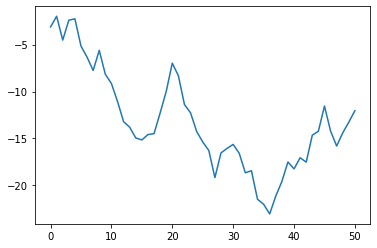

In [129]:
plt.plot(np.unwrap(np.angle(iq_mean)))

In [58]:
sr.CaptureCtrl.SAMPLING_RATE

500000000

## send_recv/send_recv.py

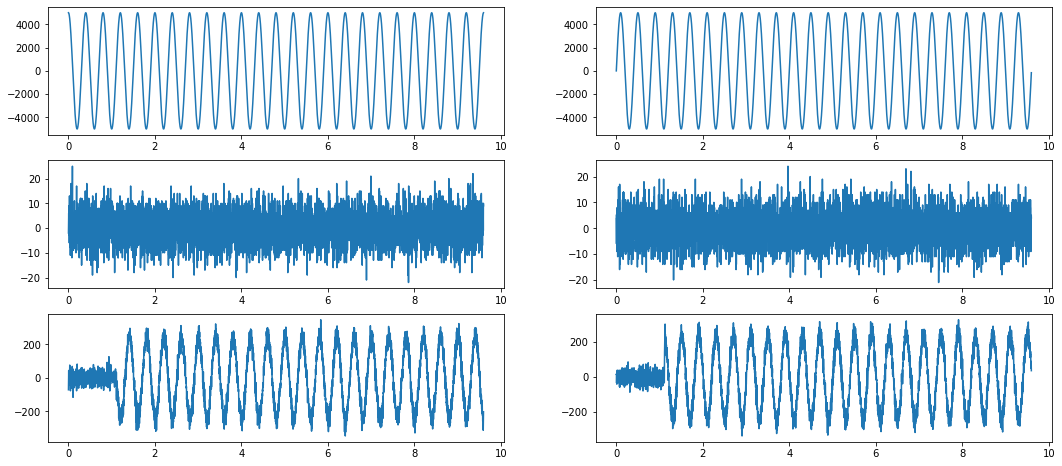

In [234]:
import e7awg_sw.examples.send_recv.send_recv as sr
from e7awg_sw.examples.send_recv.send_recv import AWG, CaptureModule

#sr.IP_ADDR = '10.1.0.23' #QUBE.config['ipfpga']
sr.IP_ADDR = QUBE.config['ipfpga']

def sendrecv(awgs, capture_modules, use_labrad, server_ip_addr):
    with (sr.create_awg_ctrl(use_labrad, server_ip_addr) as awg_ctrl,
          sr.create_capture_ctrl(use_labrad, server_ip_addr) as cap_ctrl):
        capture_units = CaptureModule.get_units(*capture_modules)
        # 初期化
        awg_ctrl.initialize(*awgs)
        cap_ctrl.initialize(*capture_units)
        # トリガ AWG の設定
        sr.set_trigger_awg(cap_ctrl, awgs[0], capture_modules)
        # 波形シーケンスの設定
        awg_to_wave_sequence = sr.set_wave_sequence(awg_ctrl, awgs)
        # キャプチャパラメータの設定
        sr.set_capture_params(cap_ctrl, awg_to_wave_sequence[awgs[0]], capture_units)
        # 波形送信スタート
        awg_ctrl.start_awgs(*awgs)
        # 波形送信完了待ち
        awg_ctrl.wait_for_awgs_to_stop(5, *awgs)
        # キャプチャ完了待ち
        cap_ctrl.wait_for_capture_units_to_stop(5, *capture_units)
        # エラーチェック
        sr.check_err(awg_ctrl, cap_ctrl, awgs, capture_units)
        # キャプチャデータ取得
        capture_unit_to_capture_data = sr.get_capture_data(cap_ctrl, capture_units)
        # 波形保存
        awg_to_wave_data = {awg: wave_seq.all_samples(False) for awg, wave_seq in awg_to_wave_sequence.items()}
    return awg_to_wave_data, capture_unit_to_capture_data
        # save_sample_data('awg', sr.AwgCtrl.SAMPLING_RATE, awg_to_wave_data)
        # save_sample_data('capture', sr.CaptureCtrl.SAMPLING_RATE, capture_unit_to_capture_data)
    # print('end')

awgs = AWG.all()
o = sendrecv(awgs, CaptureModule.all(), False, 'localhost')

%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

samples = o[1][0]
sampling_rate = sr.CaptureCtrl.SAMPLING_RATE
#sampling_rate = sr.AwgCtrl.SAMPLING_RATE
time = np.linspace(0, 1000000 * len(samples) / sampling_rate, len(samples), endpoint=False)

#print(len(samples), sampling_rate * 1e-6, time[0], time[-1])

tx_iq = np.array(o[0][0])
iq = np.array([v for k, v in o[1].items()])

f, axs = plt.subplots(3,2, figsize=(18,8))
axs[0,0].plot(time, tx_iq[:,0])
axs[0,1].plot(time, tx_iq[:,1])
axs[1,0].plot(time, iq[0,:,0])
axs[1,1].plot(time, iq[0,:,1])
axs[2,0].plot(time, iq[4,:,0])
axs[2,1].plot(time, iq[4,:,1])

# Rabi Vibration

In [ ]:
# 

## 参考資料

In [127]:
import qubelsi.qube
import inspect
import e7awgsw.awgctrl
print(inspect.getsource(qubelsi.adrf6780))
#print(inspect.getsource(qubelsi.lmx2594))
#print(inspect.getsource(qubelsi.ad9082))
#print(inspect.getsource(e7awgsw.awgctrl.AwgCtrl))

import qubelsi.udpsendrecv

class ADRF6780:

    def __init__(self, addr, path, chip):
        self.handle = qubelsi.udpsendrecv.UDPSendRecv(addr, path)
        self.chip = chip

    def read_mode(self):
        return self.handle.read_adrf6780(self.chip, 0x5)

    def set_usb(self):
        return self.handle.write_adrf6780(self.chip, 0x5, 0x0000)

    def set_lsb(self):
        return self.handle.write_adrf6780(self.chip, 0x5, 0x0400)

    def write_value(self, addr, value):
        return self.handle.write_adrf6780(self.chip, addr, value)

    def read_value(self, addr):
        return self.handle.read_adrf6780(self.chip, addr)

    def do_init(self, message_out=False, usb_mode=False):
        self.write_value(0x0, 0x4000)
        self.write_value(0x0, 0x0000)
        self.write_value(0x3, 0x0167)
        if usb_mode:
            self.write_value(0x5, 0x0000)
        else:            
            self.write_value(0x5, 0x0400)



In [31]:
print(inspect.getsource(qubelsi.lmx2594))

import qubelsi.udpsendrecv

class LMX2594:

    def __init__(self, addr, path, chip):
        self.handle = qubelsi.udpsendrecv.UDPSendRecv(addr, path)
        self.chip = chip

    def read_freq_100M(self):
        return self.handle.read_lmx2594(self.chip, 0x24)

    def write_freq_100M(self, value):
        val = self.handle.write_lmx2594(self.chip, 0x24, value)
        r0 = self.handle.read_lmx2594(self.chip, 0)
        self.handle.write_lmx2594(self.chip, 0, r0 | 0x08) # R0[3]=FCAL_EN
        return val

    def write_value(self, addr, value):
        return self.handle.write_lmx2594(self.chip, addr, value)

    def read_value(self, addr):
        return self.handle.read_lmx2594(self.chip, addr)

    def do_init(self, message_out=False, readout_mode=False, ad9082_mode=False):
        
        if ad9082_mode:
            self.write_value(0x00, 0x6612) # R6 [14]VCO_PHASE_SYNC=0
        else:
            self.write_value(0x00, 0x2612) # R6 [14]VCO_PHASE_SYNC=0, [9]OUT_MUTE=1
        

In [238]:
import qubecalib as qc
import pickle

PORT_ID = 0
VATT = 0xC00
TYPE = 'A'

qube = QUBE.qube

port = qc.new_port_handler(qube)

def set_sideband_config(adrf6780, qube_type = 'A'):
    o = adrf6780
    if qube_type == 'A':
        o[0].set_usb()
        o[1].set_usb()
        o[2].set_lsb()
        o[3].set_lsb()
        o[4].set_lsb()
        o[5].set_lsb()
        o[6].set_usb()
        o[7].set_usb()
    else:
        o[0].set_lsb()
        o[1].set_lsb()
        o[2].set_lsb()
        o[3].set_lsb()
        o[4].set_lsb()
        o[5].set_lsb()
        o[6].set_lsb()
        o[7].set_lsb()

set_sideband_config(qube.adrf6780, qube_type='A')


#fname = 'Qube{}_{}_Port{}_{}_coarse.pickle'.format(QUBE, QUBE_ID, PORT_ID, hex(VATT))
#result = []

# Readout 9500 - 11000
#   IF 1300 - 2000
#   LO 8200 - 8500 

def set_lo(port, mhz, apply=True):
    qc.set_lmx2594_freq_100M(port.losc, int(mhz*1e-2))
    if apply:
        qc.apply_lmx2594(port.losc)

def set_nco(port, mhz):
    ifdac = port.ifdac
    ifdac.ad9082.set_nco(freq=mhz*1e+6, ch=ifdac.ch)

def set_nco_ifadc(port, mhz, ch):
    ifdac = port.ifdac
    ifdac.ad9082.set_nco(freq=mhz*1e+6, ch=ch, adc_mode=True)
    
def set_lo_nco(port, lo, nco):
    set_lo(port, lo)
    set_nco(port, nco)

# 9800, 10400, 11000
FL, FI = 8200, 1500
VATT = 0x800
PORT_ID=0
set_lo_nco(port[PORT_ID], FL, FI - 2.5)
[set_nco_ifadc(port[PORT_ID], FI - 2.5, i) for i in range(4)] # とりあえず全チャンネルを設定 ADC IF 設定
qc.set_vatt(port[PORT_ID].upconv.vatt, VATT)

FL = 11200
FI = 1500
VATT = 0xC00
PORT_ID=5
set_lo_nco(port[PORT_ID], FL, FI - 2.5)
qc.set_vatt(port[PORT_ID].upconv.vatt, VATT)


2.4756043956043956